In [1]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO
from pathlib import Path

In [3]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, resnet34
torch.backends.cudnn.benchmark=True

## Models

In [4]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [5]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [6]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [7]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [8]:
def cut_model(m, cut):
    return list(m.children())[:cut] if cut else [m]

def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [9]:

model_meta = {
    resnet18:[8,6], resnet34:[8,6]
}

In [10]:
f = resnet34
cut,lr_cut = model_meta[f]

In [11]:
m = get_base()
m = Unet34(m)

In [48]:
def batchnorm_to_fp32(module):
    '''
    BatchNorm layers to have parameters in single precision.
    Find all layers and convert them back to float. This can't
    be done with built in .apply as that function will apply
    fn to all modules, parameters, and buffers. Thus we wouldn't
    be able to guard the float conversion based on the module type.
    '''
    if isinstance(module, nn.modules.batchnorm._BatchNorm):
        module.float()
    for child in module.children():
        batchnorm_to_fp32(child)
    return module
class FP16(nn.Module):
    def __init__(self, module): 
        super(FP16, self).__init__()
        self.module = batchnorm_to_fp32(module.half())
        
    def forward(self, input): 
        return self.module(input.half())
    
    def load_state_dict(self, *inputs, **kwargs):
        self.module.load_state_dict(*inputs, **kwargs)

    def state_dict(self, *inputs, **kwargs):
        return self.module.state_dict(*inputs, **kwargs)

In [49]:
m = FP16(m)

In [50]:
PATH = Path('../data/Train')

In [51]:
cuda_enabled = torch.cuda.is_available()
model_path = str(PATH/'models/600urn-pad-instead.h5')
if cuda_enabled:
    m = m.cuda()
    m.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
else:
    m.load_state_dict(torch.load(model_path))


In [52]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
  print ("Error loading video")
  quit

# Define encoder function
def encode(array):
	pil_img = Image.fromarray(array)
	buff = BytesIO()
	pil_img.save(buff, format="PNG")
	return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)


In [53]:
import matplotlib.pyplot as plt

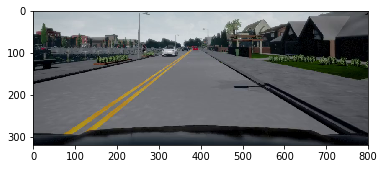

In [54]:
plt.imshow(video[0][226:546,:,:])

In [55]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [56]:
import cv2

In [57]:
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
def normalize(x):
    x = x.astype(np.float32)
    if np.mean(x) > 1:
        x /= 255.0
    m,s = imagenet_stats
    x -= m
    x /= s
    return x

def crop_bg(x):
    # Original
    h = x.shape[1]
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    return x[:,top:bot,:,:]

def pad(x):
#     print(x.shape)
    # Original
    b,c,w,h = x.shape
    print(x.shape)
    pad_right=32-h%32
    if pad_right:
        x = F.pad(x, (0,pad_right,0,0), 'constant', 0)
    return x, pad_right
    
def undo(idx):
    idx
    idx = F.pad(idx, (0,0,226,54), "constant", 0)

def preprocess(video):
#     f1 = video[:,200:520,:,:]
    f1 = crop_bg(video)
    f1 = normalize(f1)
    f1 = np.rollaxis(f1, 3, 1)
    return f1.copy(order='C')

In [58]:
video_p = preprocess(video)

In [59]:
video_p.shape

(31, 3, 384, 800)

In [60]:
import gc
gc.collect()

442

In [61]:
xv = torch.autograd.Variable(torch.from_numpy(video_p).contiguous().float())

In [62]:
results = []
answer_key = {}
bs = 4
for i in range(0,video_p.shape[0],bs):
    f1 = video_p[i:i+bs]
    
    x = torch.from_numpy(f1).contiguous().float()
    if cuda_enabled:
        x = x.cuda()
        
    x,p = pad(x)
    preds = m(x)
    mx,idx = torch.max(preds, 1)
    
    idx = F.pad(idx[:,:,:-p], (0,0,160,56), "constant", 0)
    
    # Frame numbering starts at 1
    frame_idx = 1+i
    for frame in idx:
        # Look for red cars :)
        frame = frame.data.cpu().numpy()
        results.append(frame)
        binary_car_result = (frame==1).astype('uint8')

        # Look for road :)
        binary_road_result = (frame==2).astype('uint8')

        answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]

        # Increment frame
        frame_idx+=1

torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([4, 3, 384, 800])
torch.Size([3, 3, 384, 800])


In [31]:
results[0].shape

(600, 800)

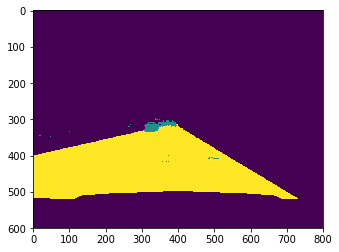

In [32]:
plt.imshow(results[0].data)

In [33]:
# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_crop', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAEUUlEQVR4nO3c3W6jMBAG0JlV3/+VvRdRWgcSAgk/xpxzVXYrxTL+bI+hiQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACA9/LoBnCcv5tfDmwFAAAAAPtwFAhvpZx0yE1dUZaIPOEzhQxPQl4RkHXkfYBlRJQ04HohICszG/dFQFaXVpCO/Du6Ab3JMOv0REDWdq/SM9K51vm5hSvLW41eKXHOsy0irCBbGEw6mb//Uv/EKbhRO7mfA987vDoWtrg0zAqyj+FEVIciFfbtEpBdjHZWOfxvy0ibTFxby1uRPvKw5RKPVgnIhiY6t0Tkk9MuWiMg33i9MLzv2DJVltAKAfnCq857sal6Q0BapEjfgCfo/fg5ugHnNS6vM8qyZ+ajbRatEZDPPBnZ1dOMnBWSkhlR8v7q1g7mtYuKKawyd/Yfd9pD1VFuK0lEGZ1UTTJ6G2QFWUUOLj6Zd+SjRYr02spjtHpNcfQhpQw/TWnfIgGpzMzHtwO5LPo0DiUg23qSgowSUcZ/TVUkpkFqkG1VKShVGR9PouOIqUX2vTe56AnGwqOph286echBdSEfTRKQD8zutL9UqDhOSkA+MLfThOL8FOkwQUA+MHNlsIB0QEA+YF96HQICEwQEJgjIcjN3WEqQHggITBCQxZToVyIgiznkvZKdAnK1v3XwZm4v